# Gray-Scott Model

This notebook is originally an idea of [@gouarin](https://github.com/gouarin)

In [1]:
import numpy as np

The reaction-diffusion system described here involves two generic chemical species U and V, whose concentration at a given point in space is referred to by variables u and v. As the term implies, they react with each other, and they diffuse through the medium. Therefore the concentration of U and V at any given location changes with time and can differ from that at other locations.

The overall behavior of the system is described by the following formula, two equations which describe three sources of increase and decrease for each of the two chemicals:


$$
\begin{array}{l}
\displaystyle \frac{\partial u}{\partial t} = D_u \Delta u - uv^2 + F(1-u) \\
\displaystyle \frac{\partial v}{\partial t} = D_v \Delta v + uv^2 - (F+k)v
\end{array}
$$

The laplacian is computed with the following numerical scheme

$$
\Delta u_{i,j} \approx u_{i,j-1} + u_{i-1,j} -4u_{i,j} + u_{i+1, j} + u_{i, j+1}
$$

The classic Euler scheme is used to integrate the time derivative.

## Initialization

$u$ is $1$ everywhere et $v$ is $0$ in the domain except in a square zone where $v = 0.25$ and $ u = 0.5$. This square located in the center of the domain is  $[0, 1]\times[0,1]$ with a size of $0.2$.


In [2]:
def init(n):

    u = np.ones((n+2,n+2))
    v = np.zeros((n+2,n+2))

    x, y = np.meshgrid(np.linspace(0, 1, n+2), np.linspace(0, 1, n+2))

    mask = (0.4<x) & (x<0.6) & (0.4<y) & (y<0.6)

    u[mask] = 0.75
    v[mask] = 0.25
    u *= np.random.uniform(.80, 1.20, size=(n+2,n+2))
    v *= np.random.uniform(.80, 1.20, size=(n+2,n+2))

    return u, v

## Boundary conditions

We assume that the domain is periodic.


In [3]:
def periodic_bc(u):
    u[0, :] = u[-2, :]
    u[-1, :] = u[1, :]
    u[:, 0] = u[:, -2]
    u[:, -1] = u[:, 1]

## Laplacian

In [4]:
def laplacian(u):
    """
    second order finite differences
    """
    return (                  u[ :-2, 1:-1] +
             u[1:-1, :-2] - 4*u[1:-1, 1:-1] + u[1:-1, 2:] +
                          +   u[2:  , 1:-1] )

## Gray-Scott model

In [5]:
def numpy_grayscott(U, V, Du, Dv, F, k):
    # V = 1-U
    u, v = U[1:-1,1:-1], V[1:-1,1:-1]

    Lu = laplacian(U)
    Lv = laplacian(V)

    uvv = u*v*v
    u += Du*Lu - uvv + F*(1 - u)
    v += Dv*Lv + uvv - (F + k)*v

    periodic_bc(U)
    periodic_bc(V)

    return U, V

## Visualization

In [6]:
## Wires
# Du, Dv = .1, .05
# F, k = 0.0545, 0.062

## Wires
Du, Dv = .1, .05
F, k = 0.029, 0.057

Du, Dv = .08, .03 ## this just acts as scaling of geometric size 
## .05 to 0.2 is roughly the range


# F, k = 0.102, 0.055 ## type rho: long patterns

In [7]:
from tqdm import tqdm
from PIL import Image
U, V = init(200)

def create_image(grayscott):
    global U, V
    for t in range(40): ## inner loop s.t. the visualized time steps are big enough
        U, V = grayscott(U, V, Du, Dv, F, k)
    V_scaled = np.uint8(255*(V-V.min()) / (V.max()-V.min()))
    return V_scaled

def create_frames(n, grayscott):
    return [create_image(grayscott) for i in tqdm(range(n))]

frames = create_frames(400, numpy_grayscott)

100%|██████████| 400/400 [00:14<00:00, 27.43it/s]


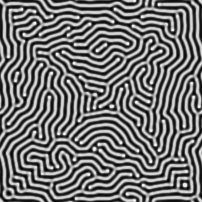

In [8]:
Image.fromarray(frames[-1])

In [9]:
from ipywidgets import interact, IntSlider

def display_sequence(iframe):
    return Image.fromarray(frames[iframe])

interact(display_sequence,
         iframe=IntSlider(min=0,
                          max=len(frames)-1,
                          step=1,
                          value=0,
                          continuous_update=True))

interactive(children=(IntSlider(value=0, description='iframe', max=399), Output()), _dom_classes=('widget-inte…

<function __main__.display_sequence(iframe)>

## References

- [Reaction-Diffusion by the Gray-Scott Model: Pearson's Parametrization](https://mrob.com/pub/comp/xmorphia/)